<a href="https://colab.research.google.com/github/ultra151/cv/blob/main/12_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras.models import Model
from IPython.display import display
from IPython.display import Image as _Imgdis
from keras.preprocessing.image import array_to_img, img_to_array, load_img

image_path = '/content/gdrive/MyDrive/pytest_img/opencv/'
save_path = '/content/gdrive/MyDrive/pytest_img/_generated_images/'

base_image_path = image_path + 'seoul.png'
style_reference_image_path = image_path + 'starnight.png'


In [ ]:
import os

if not os.path.exists(os.path.join(save_path, "neural_style/")):
    os.makedirs(os.path.join(os.path.join(save_path, "neural_style/")))

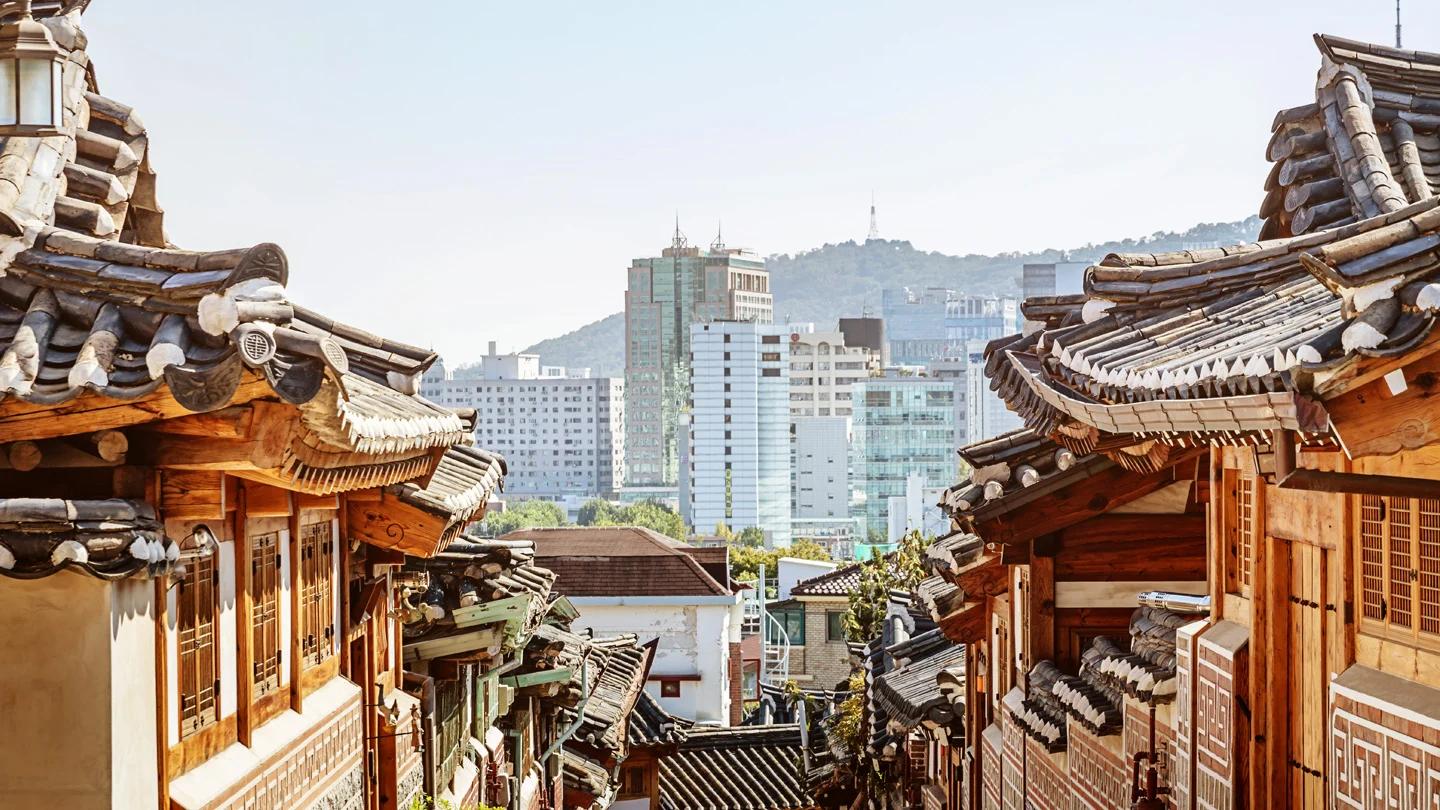

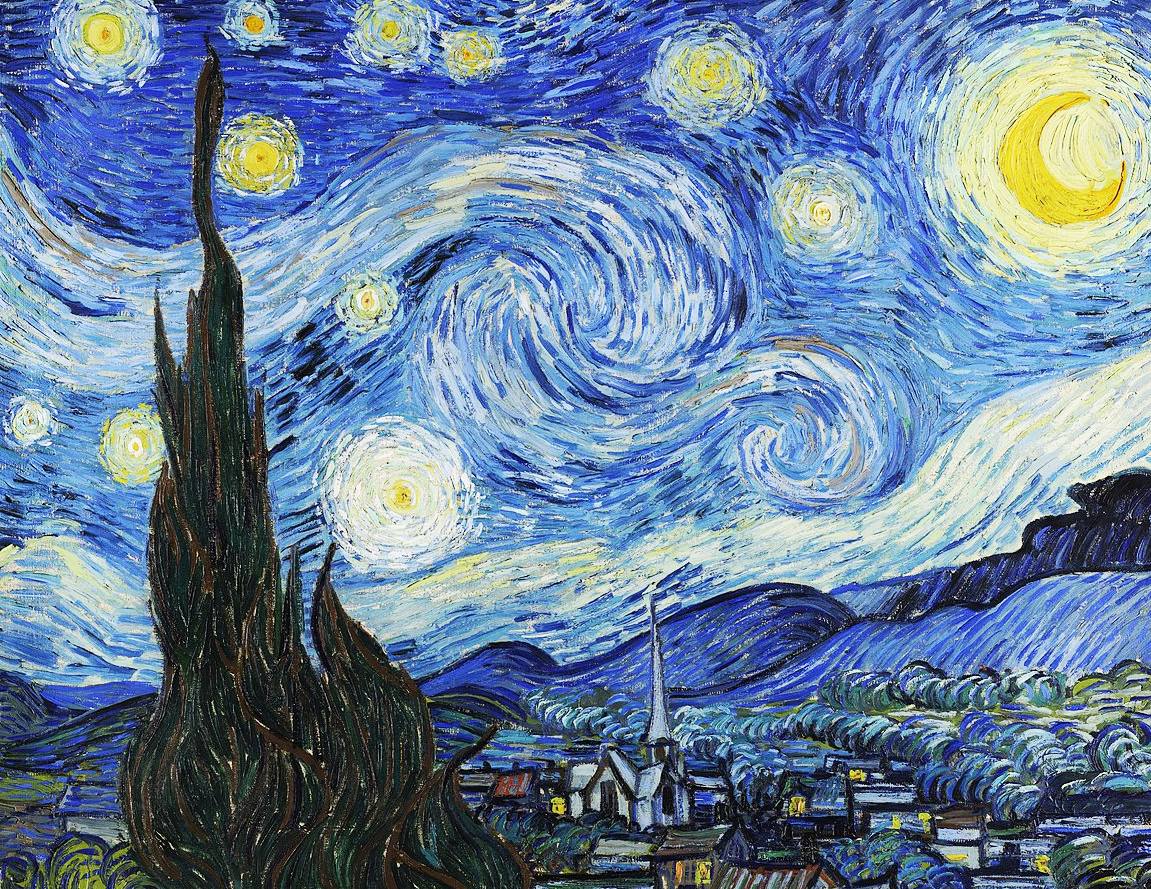

In [ ]:
img_height = 400
img_width = 600
display(_Imgdis(filename=base_image_path, height=img_height, width=img_width))
display(_Imgdis(filename=style_reference_image_path, height=img_height, width=img_width))

In [ ]:
import numpy as np
import tensorflow as tf

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [ ]:
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
model = VGG19(weights="imagenet", include_top=False)

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
feature_extractor.outputs

[<KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_45>,
 <KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_46>,
 <KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_47>,
 <KerasTensor shape=(None, None, None, 128), dtype=float32, sparse=False, name=keras_tensor_48>,
 <KerasTensor shape=(None, None, None, 128), dtype=float32, sparse=False, name=keras_tensor_49>,
 <KerasTensor shape=(None, None, None, 128), dtype=float32, sparse=False, name=keras_tensor_50>,
 <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_51>,
 <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_52>,
 <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_53>,
 <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_54>,
 <KerasTensor shape=(None, None, 

In [ ]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [ ]:
def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def total_variation_loss(x):
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features, combination_features)

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)

    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.90
    )
)

In [ ]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

In [ ]:
from tensorflow import keras
iterations = 4000

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"{i}번째 반복:loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(os.path.join(save_path, "neural_style/", fname), img)


100번째 반복:loss=12425.71
200번째 반복:loss=9810.80
300번째 반복:loss=8782.66
400번째 반복:loss=8215.71
500번째 반복:loss=7849.37
600번째 반복:loss=7590.13
700번째 반복:loss=7396.40
800번째 반복:loss=7245.33
900번째 반복:loss=7124.18
1000번째 반복:loss=7025.19
1100번째 반복:loss=6943.02
1200번째 반복:loss=6873.79
1300번째 반복:loss=6814.77
1400번째 반복:loss=6764.10
1500번째 반복:loss=6720.37
1600번째 반복:loss=6682.46
1700번째 반복:loss=6649.46
1800번째 반복:loss=6620.62
1900번째 반복:loss=6595.30
2000번째 반복:loss=6573.04
2100번째 반복:loss=6553.38
2200번째 반복:loss=6535.96
2300번째 반복:loss=6520.53
2400번째 반복:loss=6506.83
2500번째 반복:loss=6494.66
2600번째 반복:loss=6483.82
2700번째 반복:loss=6474.15
2800번째 반복:loss=6465.52
2900번째 반복:loss=6457.82
3000번째 반복:loss=6450.94
3100번째 반복:loss=6444.79
3200번째 반복:loss=6439.29
3300번째 반복:loss=6434.36
3400번째 반복:loss=6429.95
3500번째 반복:loss=6425.99
3600번째 반복:loss=6422.44
3700번째 반복:loss=6419.25
3800번째 반복:loss=6416.40
3900번째 반복:loss=6413.83
4000번째 반복:loss=6411.53
